Analysis of Bike Sharing Data Set

1- Load Packages and Read Data

In [119]:
#Loading Packages
library(data.table) # for reading and manipulation of data
library(dplyr)      # for data manipulation and joining 
library(ggplot2)    # for ploting 
library(corrplot)   # for making correlation plot 
library(ggExtra)    # for plotting
library(caret)      # for one hot encoding
library(tree)       #for Tree Model
library(randomForest) #for RF  model
library(tseries)    # for Stationarity test
library(vars)       # VARS PACKAGE for granger causality

In [94]:
#Read Files
hour = fread("hour.csv")

2-Check the Data

In [96]:
#Have a look at the data
head(hour)
str(hour)
hour$instant<-NULL   #The Id is not used in prediction, it is also removed

dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1


Classes ‘data.table’ and 'data.frame':	17379 obs. of  16 variables:
 $ dteday    : chr  "2011-01-01" "2011-01-01" "2011-01-01" "2011-01-01" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mnth      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ weekday   : int  6 6 6 6 6 6 6 6 6 6 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weathersit: int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ atemp     : num  0.288 0.273 0.273 0.288 0.288 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ cnt       : int  16 40 32 13 1 1 2 3 8 14 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Warning message in `[<-.data.table`(x, j = name, value = value):
“Column 'instant' does not exist to remove”

3-Data Preparation

    3.1 Variable type conversion

In [97]:
#Since the categorical variable (according to data description) is imported as "int",
#there is a need of type conversion
#Season,yr,mnth,hr,holiday,weekday,workingday,wearhersit
hour$season <- as.factor(hour$season)
hour$yr <- as.factor(hour$yr)
hour$mnth <- as.factor(hour$mnth)
hour$hr <- as.factor(hour$hr)
hour$holiday <- as.factor(hour$holiday)
hour$weekday <- as.factor(hour$weekday)
hour$workingday <- as.factor(hour$workingday)
hour$weathersit <- as.factor(hour$weathersit)
str(hour)

Classes ‘data.table’ and 'data.frame':	17379 obs. of  16 variables:
 $ dteday    : chr  "2011-01-01" "2011-01-01" "2011-01-01" "2011-01-01" ...
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mnth      : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weekday   : Factor w/ 7 levels "0","1","2","3",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weathersit: Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ atemp     : num  0.288 0.273 0.273 0.288 0.288 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ casual    : int  3

In [98]:
hour[, dteday:=as.Date(dteday)] #Convert char to date
print(paste("The dataset has a range from", min(hour$dteday),"to" ,max(hour$dteday)))
print(paste("The dataset has ", max(hour$dteday)-min(hour$dteday)+1,"days"))
#There are data for 2011 and 2012 for everyday.
print(paste("There are total", nrow(hour),"observations for hourly data"))
#Check Missing Data
print(paste("The total number of missing data are",sum(is.na(hour))))

[1] "The dataset has a range from 2011-01-01 to 2012-12-31"
[1] "The dataset has  731 days"
[1] "There are total 17379 observations for hourly data"
[1] "The total number of missing data are 0"


    3.3 Missing variable

In [146]:
summary(hour)
##Missing Values##
na_count <-sapply(hour, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count
#No Missing value

     dteday           season   yr            mnth            hr       
 Min.   :2011-01-01   1:4242   0:8645   5      :1488   16     :  730  
 1st Qu.:2011-07-04   2:4409   1:8734   7      :1488   17     :  730  
 Median :2012-01-02   3:4496            12     :1483   13     :  729  
 Mean   :2012-01-02   4:4232            8      :1475   14     :  729  
 3rd Qu.:2012-07-02                     3      :1473   15     :  729  
 Max.   :2012-12-31                     10     :1451   12     :  728  
                                        (Other):8521   (Other):13004  
 holiday   weekday  workingday weathersit      temp           atemp       
 0:16879   0:2502   0: 5514    1:11413    Min.   :0.020   Min.   :0.0000  
 1:  500   1:2479   1:11865    2: 4544    1st Qu.:0.340   1st Qu.:0.3333  
           2:2453              3: 1419    Median :0.500   Median :0.4848  
           3:2475              4:    3    Mean   :0.497   Mean   :0.4758  
           4:2471                         3rd Qu.:0.660  

,na_count
,<int>
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2012-12-29,1,1,12,22,0,6,0,2,0.26,0.2424,0.60,0.4627,3,51,54
2012-12-29,1,1,12,23,0,6,0,2,0.26,0.2424,0.60,0.0000,0,32,32
2012-12-30,1,1,12,0,0,0,0,2,0.26,0.2576,0.60,0.1642,0,41,41
2012-12-30,1,1,12,1,0,0,0,2,0.26,0.2273,0.56,0.4179,1,27,28
2012-12-30,1,1,12,2,0,0,0,2,0.26,0.2424,0.56,0.2836,0,19,19
2012-12-30,1,1,12,3,0,0,0,2,0.26,0.2273,0.56,0.4179,1,14,15
2012-12-30,1,1,12,4,0,0,0,2,0.26,0.2576,0.56,0.2239,0,7,7
2012-12-30,1,1,12,5,0,0,0,2,0.26,0.2273,0.48,0.2985,0,2,2
2012-12-30,1,1,12,6,0,0,0,2,0.24,0.1970,0.52,0.4179,1,7,8


    3.2 Splitting data to test and train data
    
    The assumption is that for the visualization and some feature engineering, I do not have test data.

In [150]:
# Split into training and test sets
# Since it is time series data, %75 of the data will be used as train and 25% of the data will be used as test data
train <- hour %>%
    filter(dteday < "2012-07-01")
tail(train)
test <- hour %>%
    filter(dteday >= "2012-07-01")
head(test)
y<-test$cnt# The actual data that we will predict is labeled as y
#y
#test$cnt<- 0
head(test)
data=rbind(train,test)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
12998,2012-06-30,3,1,6,18,0,6,0,1,0.88,0.7879,0.35,0.0000,91,248,339
12999,2012-06-30,3,1,6,19,0,6,0,1,0.84,0.7576,0.44,0.2537,134,240,374
13000,2012-06-30,3,1,6,20,0,6,0,1,0.82,0.7727,0.52,0.1642,88,204,292
13001,2012-06-30,3,1,6,21,0,6,0,1,0.82,0.7727,0.52,0.1642,48,165,213
13002,2012-06-30,3,1,6,22,0,6,0,1,0.78,0.7424,0.62,0.1642,38,134,172
13003,2012-06-30,3,1,6,23,0,6,0,1,0.78,0.7424,0.62,0.0896,33,119,152


dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2012-07-01,3,1,7,0,0,0,0,1,0.76,0.7273,0.66,0.0000,27,122,149
2012-07-01,3,1,7,1,0,0,0,1,0.74,0.6970,0.70,0.1343,12,81,93
2012-07-01,3,1,7,2,0,0,0,1,0.72,0.6970,0.74,0.0896,21,69,90
2012-07-01,3,1,7,3,0,0,0,1,0.72,0.7121,0.84,0.1343,6,27,33
2012-07-01,3,1,7,4,0,0,0,1,0.70,0.6667,0.79,0.1940,0,4,4
2012-07-01,3,1,7,5,0,0,0,1,0.68,0.6364,0.79,0.1045,3,7,10


dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2012-07-01,3,1,7,0,0,0,0,1,0.76,0.7273,0.66,0.0000,27,122,149
2012-07-01,3,1,7,1,0,0,0,1,0.74,0.6970,0.70,0.1343,12,81,93
2012-07-01,3,1,7,2,0,0,0,1,0.72,0.6970,0.74,0.0896,21,69,90
2012-07-01,3,1,7,3,0,0,0,1,0.72,0.7121,0.84,0.1343,6,27,33
2012-07-01,3,1,7,4,0,0,0,1,0.70,0.6667,0.79,0.1940,0,4,4
2012-07-01,3,1,7,5,0,0,0,1,0.68,0.6364,0.79,0.1045,3,7,10


3.3 Checking Autocorrelation

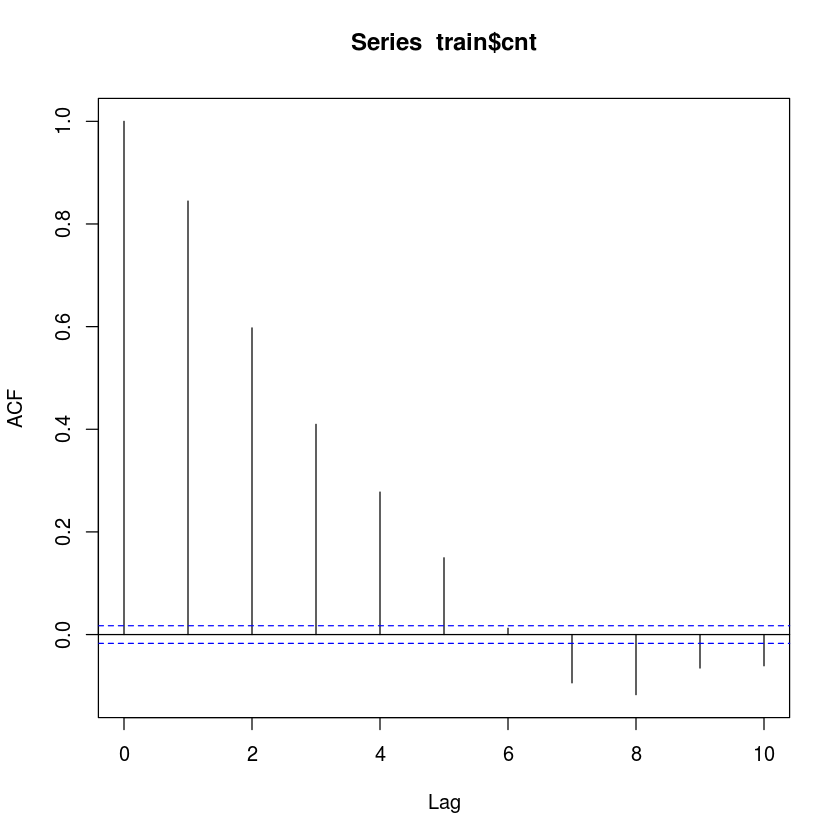

In [151]:
# Checkign ACF
acf(x=train$cnt, lag.max=10 , plot=TRUE)

In [152]:
#Add first 3 lags to the combined data set
#creating lag values
dim(data)
data$lag1<-0
data$lag2<-0
data$lag3<-0

data$lag1[2:17379]=data$cnt[1:17378]
data$lag2[3:17379]=data$cnt[1:17377]
data$lag3[4:17379]=data$cnt[1:17376]
head(data)
tail(data)

[1] 17379    16

dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,lag1,lag2,lag3
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,0,0,0
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,16,0,0
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,40,16,0
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,32,40,16
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,13,32,40
2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,1,13,32


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,lag1,lag2,lag3
,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
17374,2012-12-31,1,1,12,18,0,1,1,2,0.26,0.2727,0.48,0.1343,10,112,122,164,214,315
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,122,164,214
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,119,122,164
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,89,119,122
17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,90,89,119
17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49,61,90,89


    3.4 Correlation Matrix for train data

'data.frame':	17379 obs. of  19 variables:
 $ dteday    : Date, format: "2011-01-01" "2011-01-01" ...
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mnth      : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weekday   : Factor w/ 7 levels "0","1","2","3",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weathersit: Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ atemp     : num  0.288 0.273 0.273 0.288 0.288 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int 

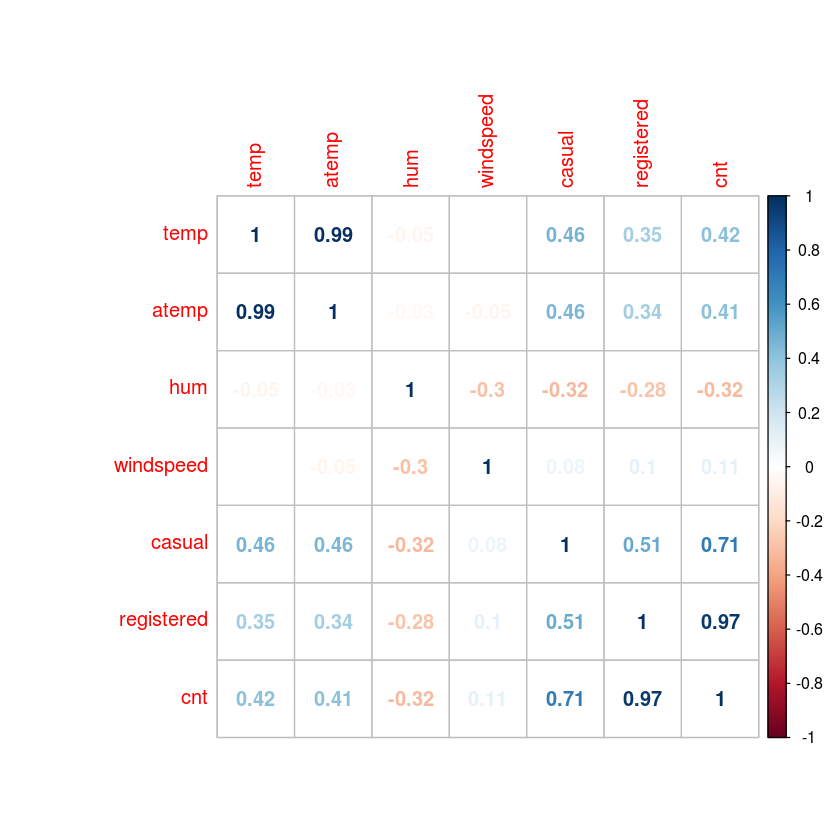

In [153]:
num<-select_if(train, is.numeric)#Extract numeric variables
#head(num)
M<-cor(num)# Correlation of numeric variables
corrplot(M,method = "number")#Correlation Plot
str(data)
#From the below correlation table, it seems that casual and registered users have different reactions 
#to weather conditions. That is why it could be better to predict for these two variables seperately and add them to
#find the cnt.

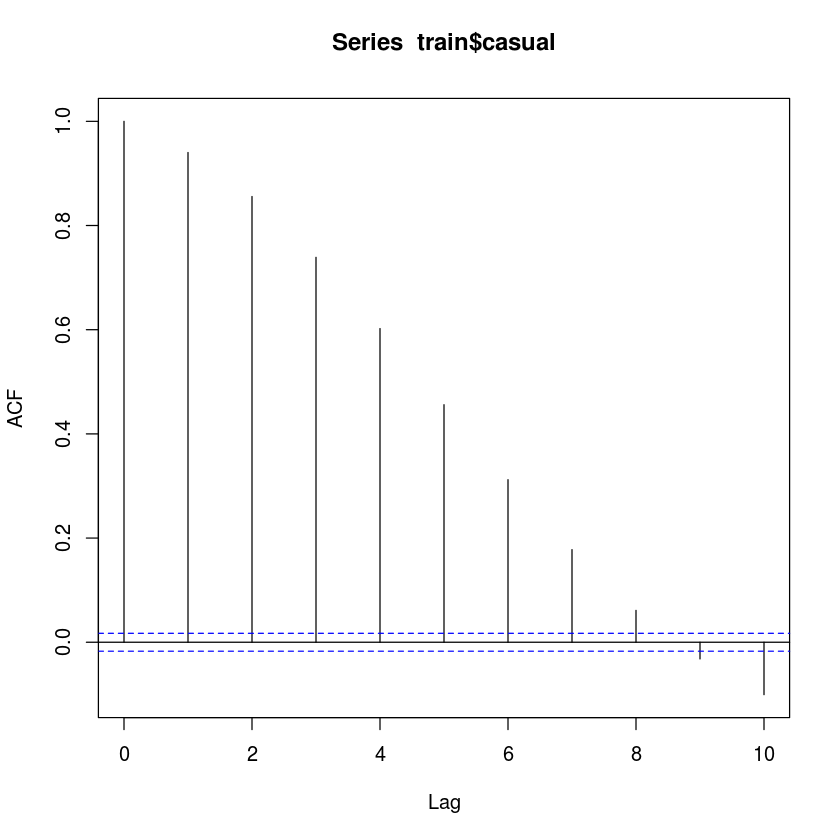

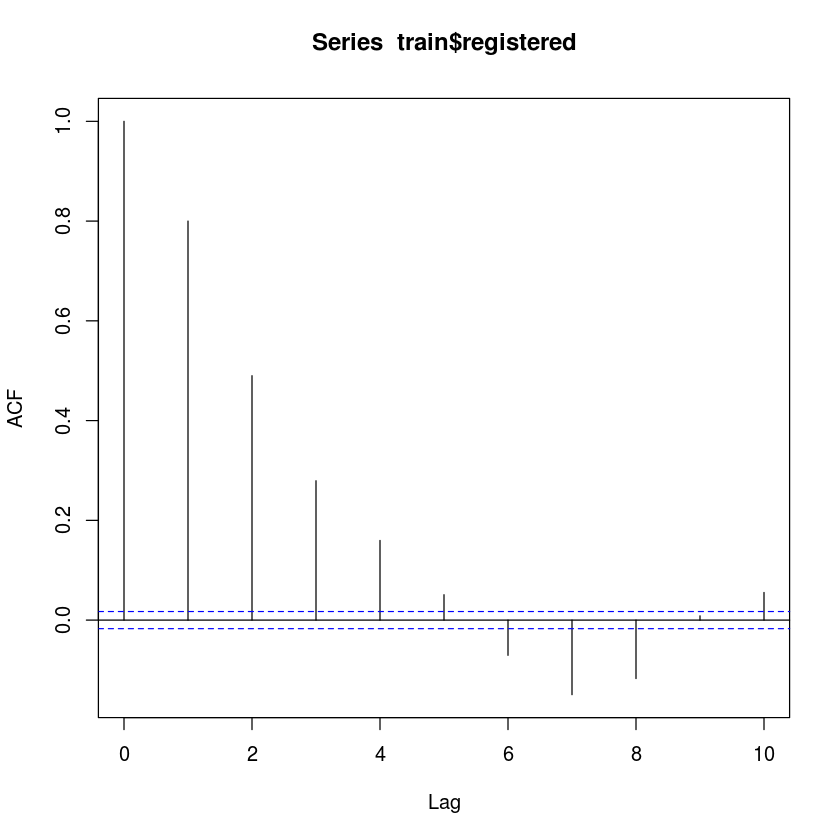

In [154]:
#casual and registered
#although from the above correlation table, it seems they are different and it could be better to predict them seperatly
#for the sake of simplicity, I will exclude them. If we include them then all calculations should be updated.
#For example acf should be calculated for them seperately. Also Granger-Causality will be done for cnt. 
#It also should be done for these two variables.
#As can be seen from below table they have different  acf lags in terms of importance

#casual and registered
acf(x=train$casual, lag.max=10 , plot=TRUE)
acf(x=train$registered, lag.max=10 , plot=TRUE)

data$casual<-NULL
data$registered<-NULL


    3.5 Histogram of Numeric Variables

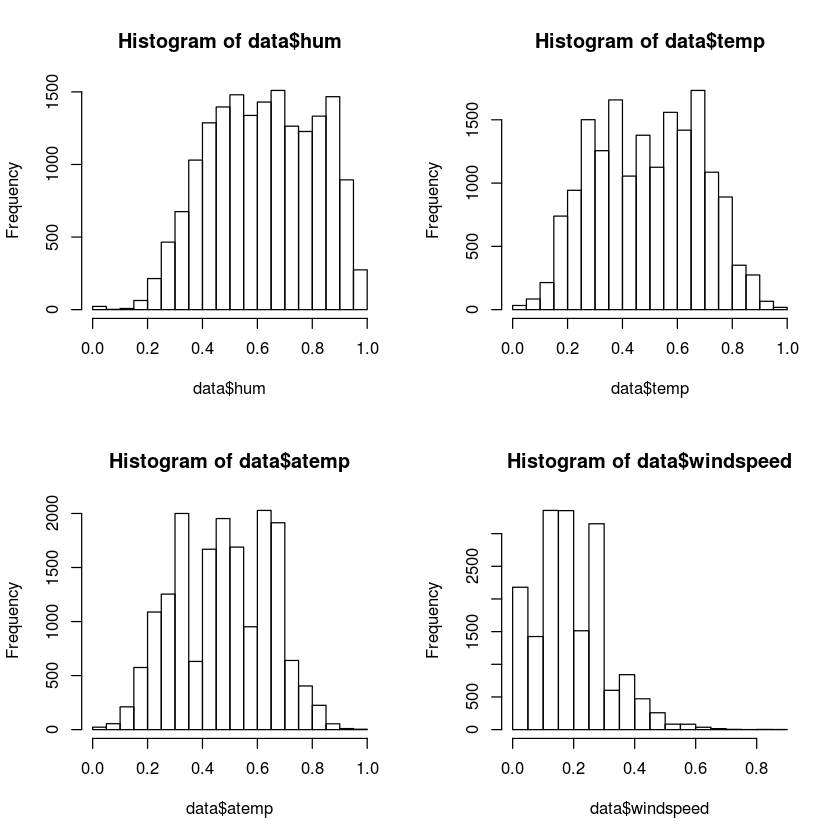

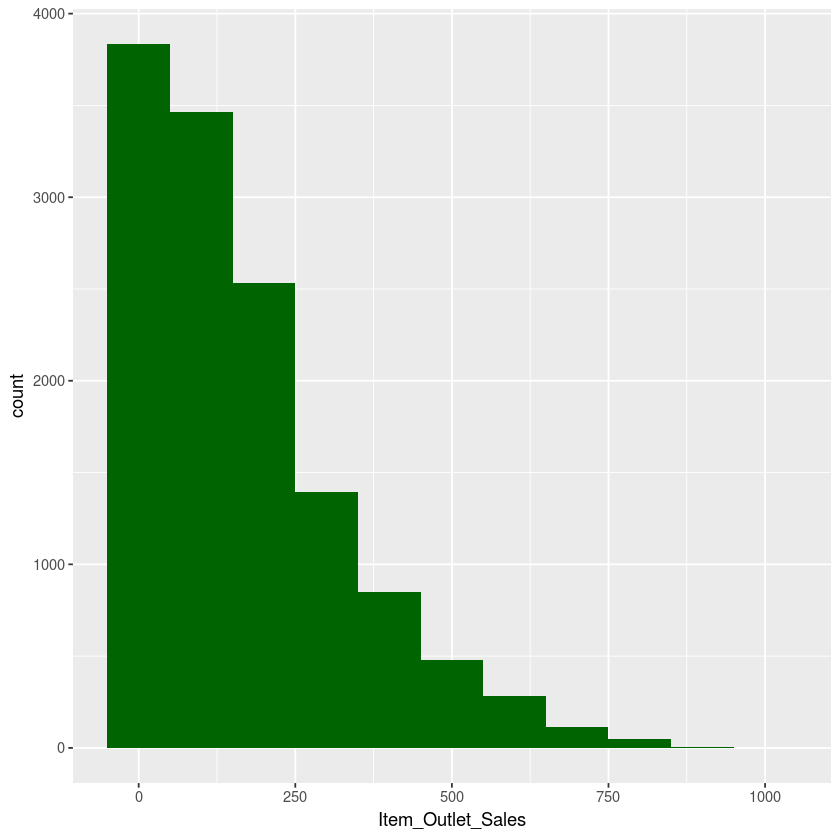

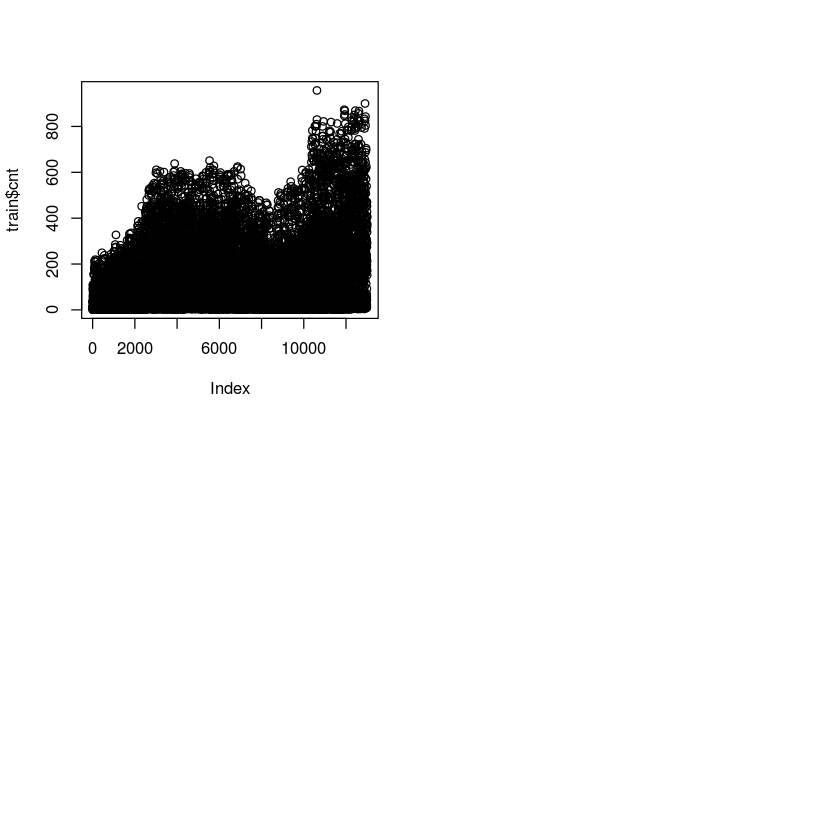

In [155]:
par(mfrow=c(2,2))
#par(mar = rep(2, 4))
hist(data$hum)
hist(data$temp)
hist(data$atemp)
hist(data$windspeed)
#Variables temp, atemp, hum and windspeed  looks naturally distributed
ggplot(train) + geom_histogram(aes(train$cnt), binwidth = 100, fill = "darkgreen") +  
    xlab("Item_Outlet_Sales")
#As can be seen, it is a right skewd 
plot(train$cnt)


4- Categorical Data Visualization

    4.1 Year Effect

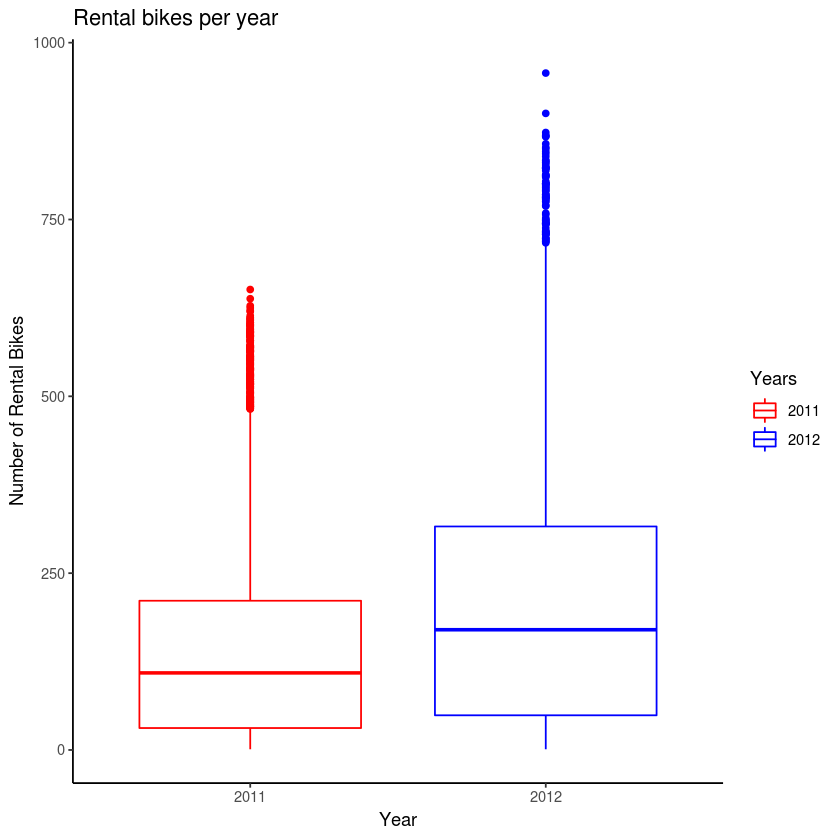

In [75]:
ggplot(train %>% group_by(yr))  +   
    geom_boxplot(aes(as.factor(yr), cnt,color=as.factor(yr)))+
    theme_classic() +
    scale_x_discrete(labels = c("2011","2012"))+
    labs(y="Number of Rental Bikes",x="Year",title = "Rental bikes per year",color='Years')+
    scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
    scale_fill_discrete(name = "Year", labels = c("2011", "2012"))


    4.2 Month and Year Effect

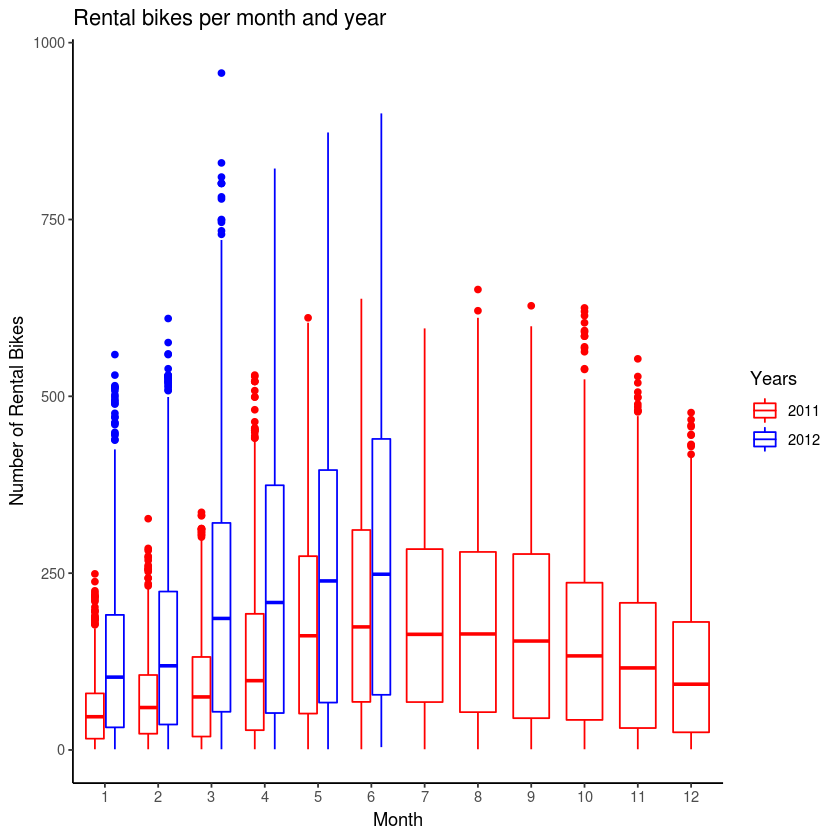

In [156]:
ggplot(train)  +   
    geom_boxplot(aes(as.factor(mnth), cnt,color=as.factor(yr)))+
    theme_classic() +
    labs(y="Number of Rental Bikes",x="Month",title = "Rental bikes per month and year ",color='Years')+
    scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
    scale_fill_discrete(name = "Year", labels = c("2011", "2012"))

    4.3 Season and Year Effect

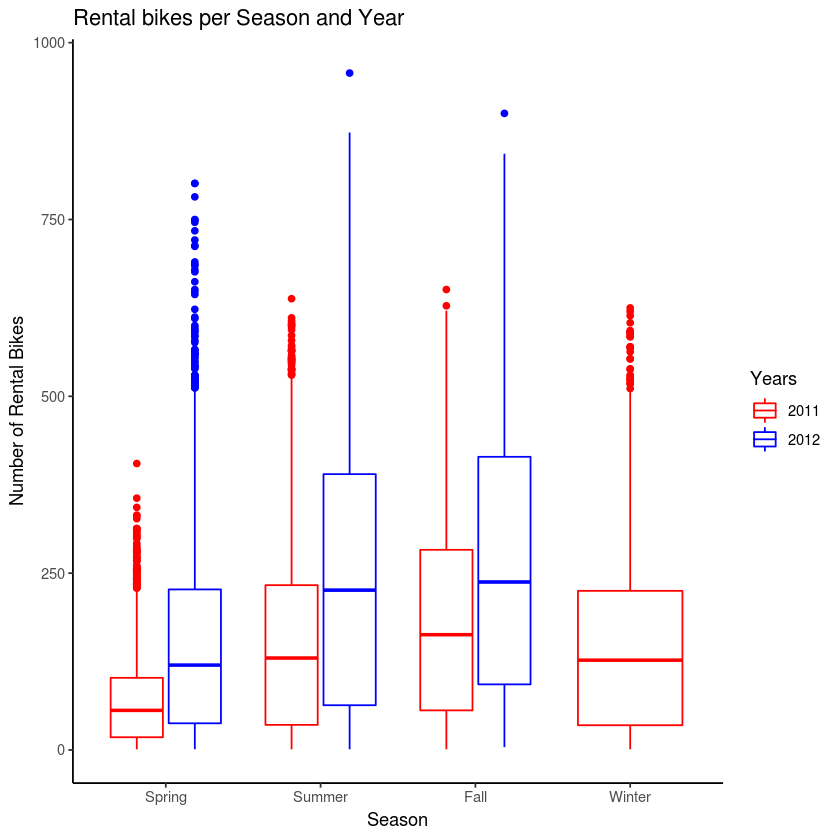

In [77]:
ggplot(train)  +   
    geom_boxplot(aes(as.factor(season), cnt,color=as.factor(yr)))+
    theme_classic() +
    labs(y="Number of Rental Bikes",x="Season",title = "Rental bikes per Season and Year",color='Years')+
    scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
    scale_fill_discrete(name = "Year", labels = c("2011", "2012"))+
    scale_x_discrete(labels = c("Spring","Summer","Fall","Winter"))

    4.4 Hour and Year Effect

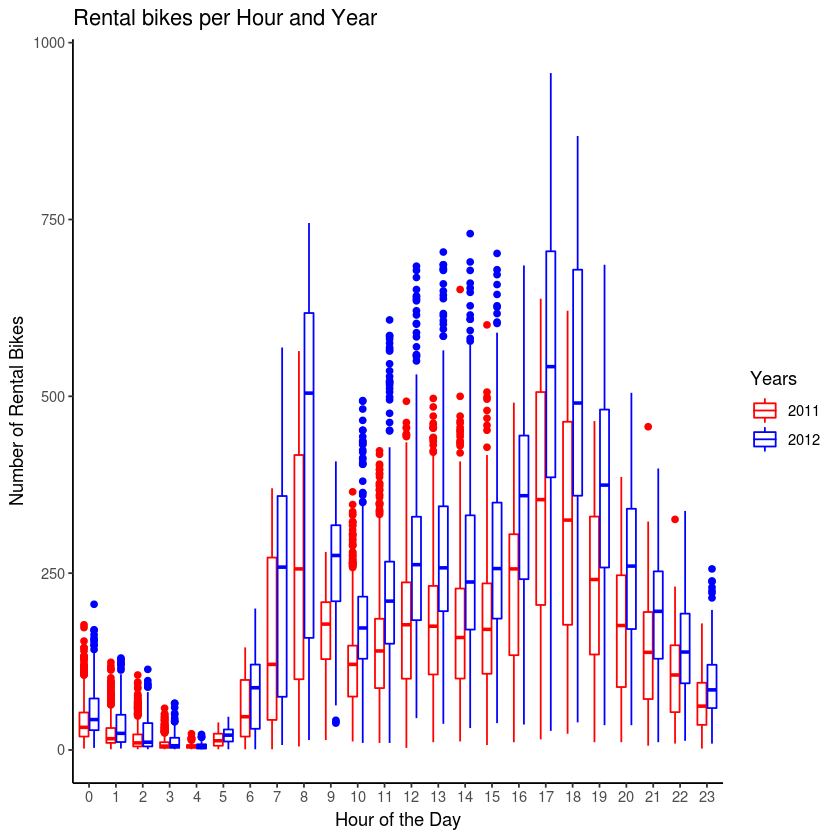

In [78]:
    ggplot(train)  +   
        geom_boxplot(aes(as.factor(hr), cnt,color=as.factor(yr)))+
        theme_classic() +
        labs(y="Number of Rental Bikes",x="Hour of the Day",title = "Rental bikes per Hour and Year",color='Years')+
        scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
        scale_fill_discrete(name = "Year", labels = c("2011", "2012"))

    4.5 Holiday day and Year Effect

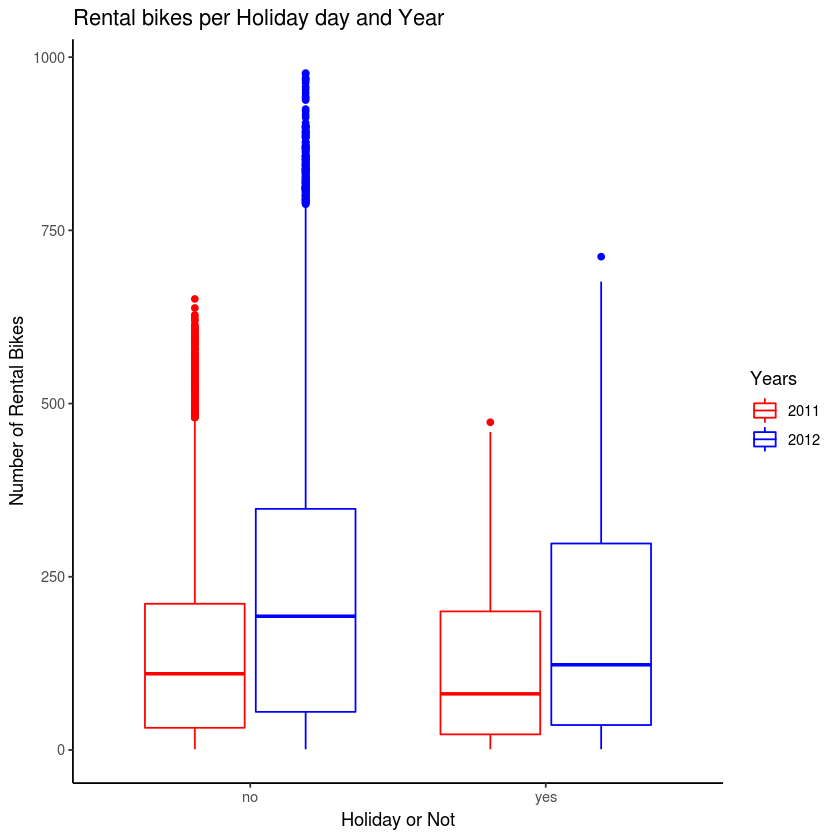

In [79]:
    ggplot(hour)  +   
        geom_boxplot(aes(as.factor(holiday), cnt,color=as.factor(yr)))+
        theme_classic() +
        labs(y="Number of Rental Bikes",x="Holiday or Not",title = "Rental bikes per Holiday day and Year",color='Years')+
        scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
        scale_fill_discrete(name = "Year", labels = c("2011", "2012"))+
        scale_x_discrete(labels = c("no","yes"))

    4.6 Weekday and Year Effect

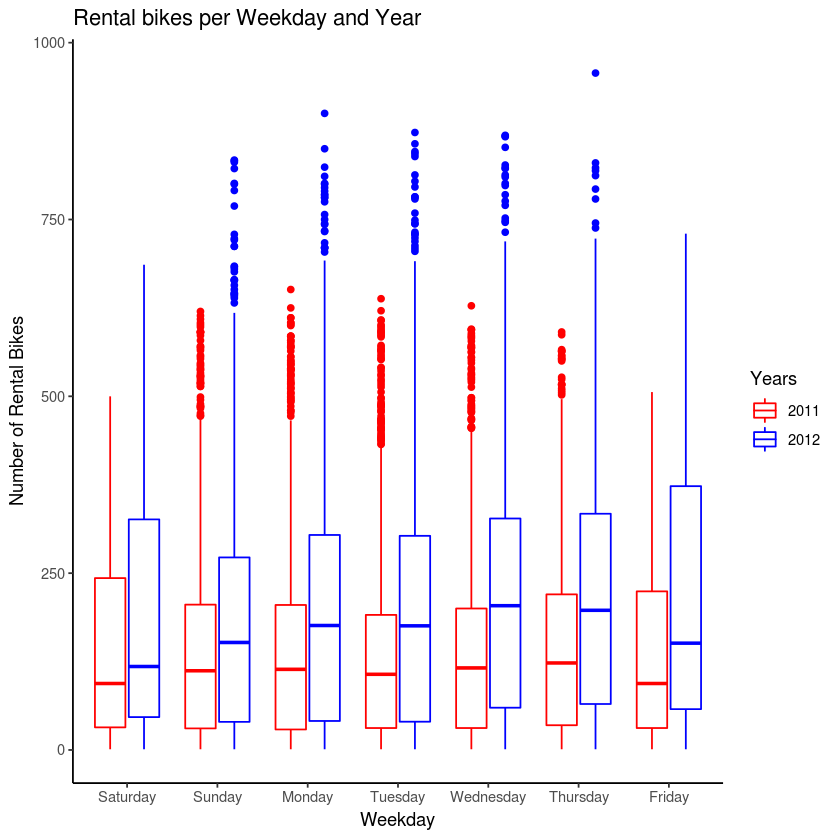

In [80]:
ggplot(train)  +   
        geom_boxplot(aes(as.factor(weekday), cnt,color=as.factor(yr)))+
        theme_classic() +
        labs(y="Number of Rental Bikes",x="Weekday",title = "Rental bikes per Weekday and Year",color='Years')+
        scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
        scale_fill_discrete(name = "Year", labels = c("2011", "2012"))+
        scale_x_discrete(labels = c("Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"))
#str(train)
#head(train)

    4.7 Weather Situtaion and Year Effect

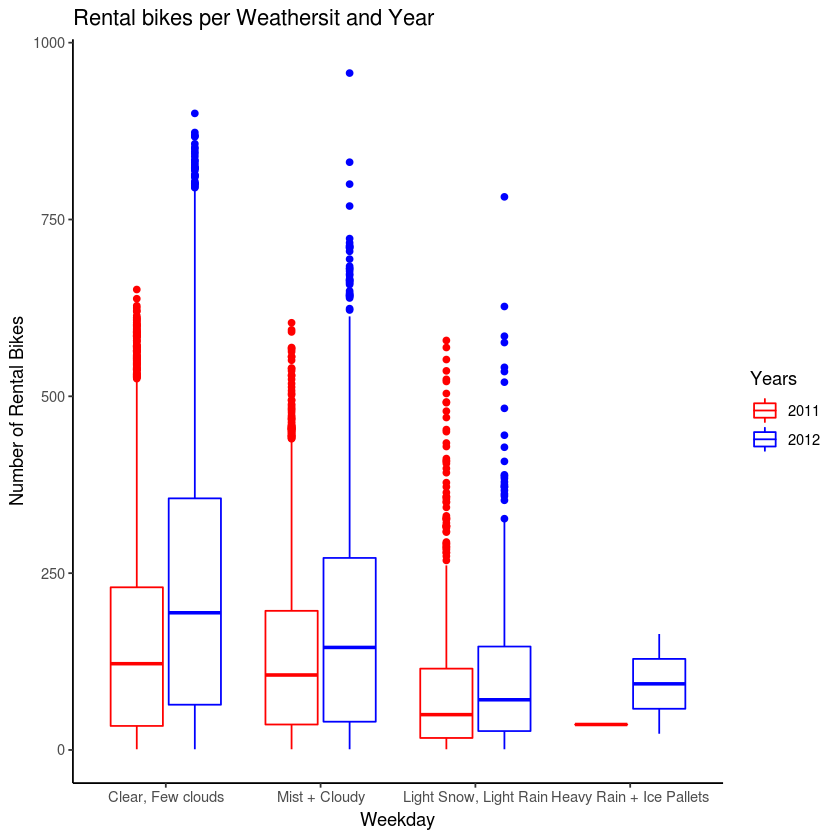

In [81]:
ggplot(train)  +   
        geom_boxplot(aes(as.factor(weathersit), cnt,color=as.factor(yr)))+
        theme_classic() +
        labs(y="Number of Rental Bikes",x="Weekday",title = "Rental bikes per Weathersit and Year",color='Years')+
        scale_color_manual(labels = c("2011", "2012"), values = c("red", "blue"))+
        scale_fill_discrete(name = "Year", labels = c("2011", "2012"))+
        scale_x_discrete(labels = c("Clear, Few clouds","Mist + Cloudy","Light Snow, Light Rain","Heavy Rain + Ice Pallets"))

    4.8 Average Rental bikes per Hours for each Season

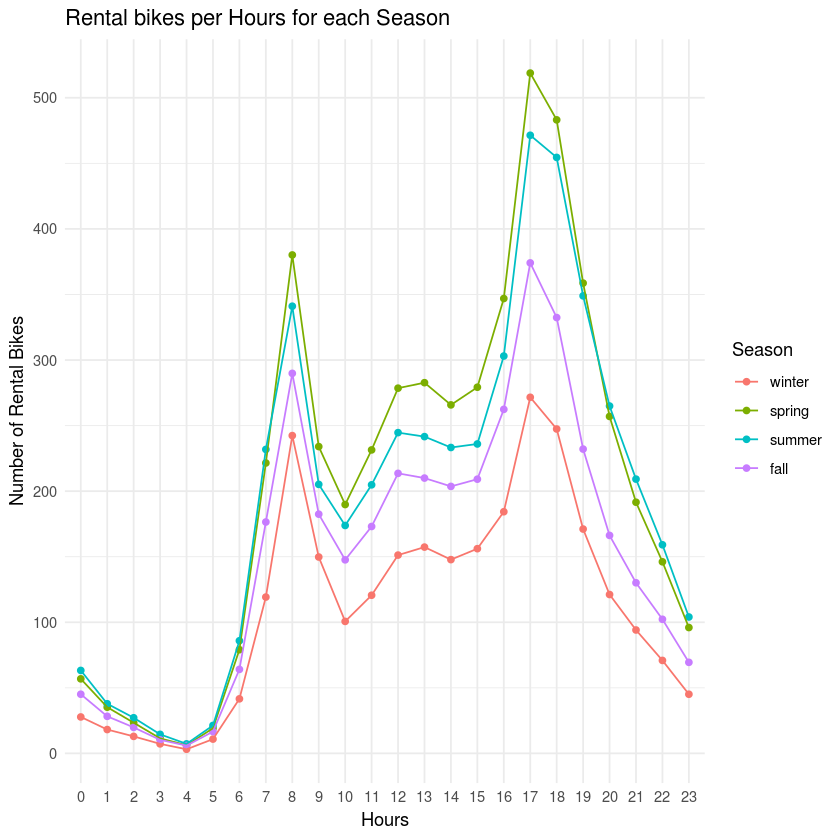

In [83]:
# Get the average count of bikes rent by season, hour 
season_mean<-train%>%
    select(season,hr,cnt)%>%group_by(season,hr)%>%summarize(cnt=mean(cnt))
#head(season_sum)
ggplot(season_mean, aes(x=hr, y=cnt, color=season))+
    geom_point(data = season_mean, aes(group = season))+
    geom_line(data = season_mean, aes(group = season))+
    ggtitle("Bikes Rent By Season")+ theme_minimal()+
    scale_colour_hue('Season',breaks = levels(hour$season),labels=c( 'winter','spring', 'summer', 'fall'))+
    labs(y="Number of Rental Bikes",x="Hours",title = "Rental bikes per Hours for each Season")

    4.9 Average Rental bikes per Hour for each Weekday

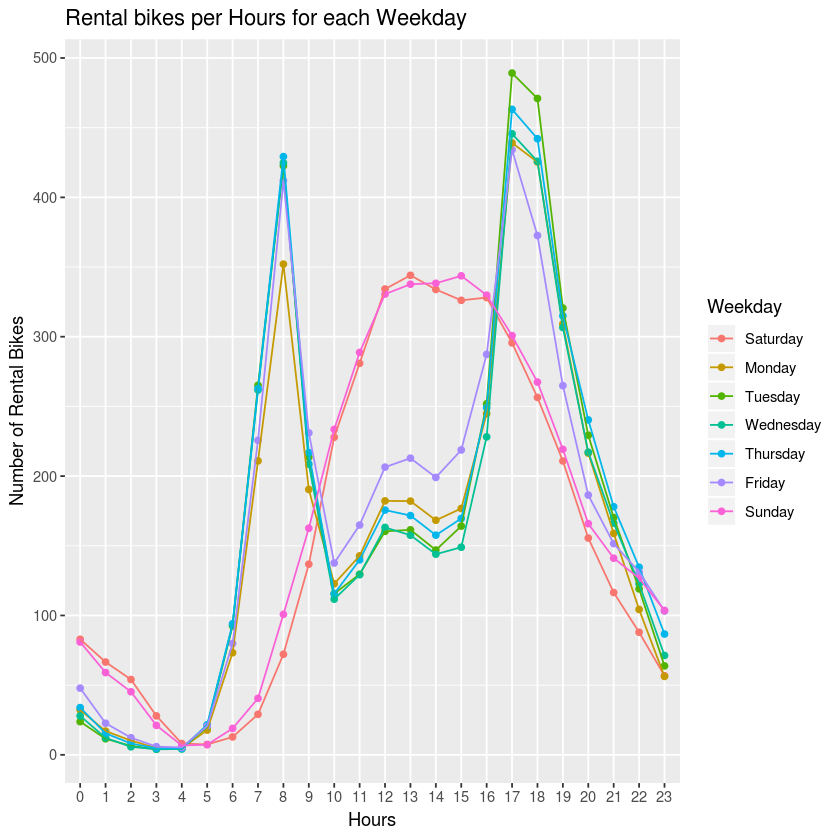

In [84]:
# Get the average count of bikes rent by season, hour 
daily_avg<-train%>%
    select(weekday,hr,cnt)%>%group_by(weekday,hr)%>%summarize(cnt=mean(cnt))
#head(daily_sum)
ggplot(daily_avg, aes(x=hr, y=cnt, color=weekday))+
    geom_point(data = daily_avg, aes(group = weekday))+
    geom_line(data = daily_avg, aes(group = weekday))+
    ggtitle("Rental Bikes By Weekday")+ scale_colour_hue('Weekday',breaks = levels(hour$weekday),
        labels=c('Saturday','Monday','Tuesday','Wednesday','Thursday','Friday','Sunday'))+
    labs(y="Number of Rental Bikes",x="Hours",title = "Rental bikes per Hours for each Weekday")


5- Continuous Data Visualization

    5.1 Temperature Effect

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


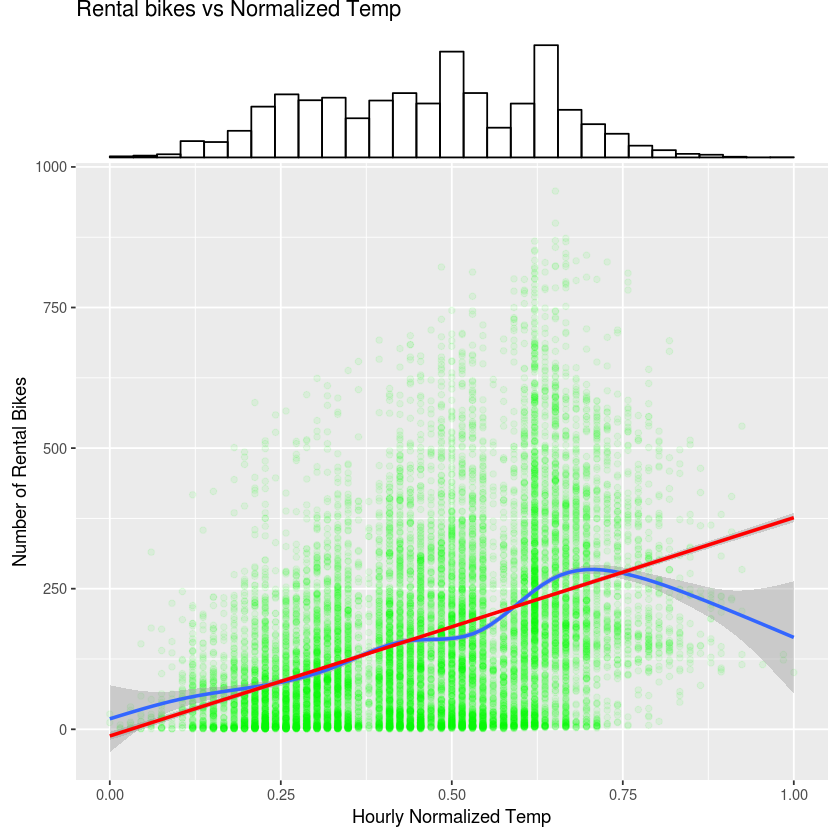

In [85]:
#From correlation table, it was positively correlated
g1<-ggplot(train,aes(x=atemp,y=cnt)) +
    geom_point(alpha=0.07, color='green')+
    labs(x="Hourly Normalized Temp",y="Number of Rental Bikes",
         title = "Rental bikes vs Normalized Temp")+
    geom_smooth(method='auto')+
    geom_smooth(method='lm',color= 'red')
ggMarginal(g1, type = "histogram",fill="transparent", margins=c("x"))


5.2 Humidity Effect

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


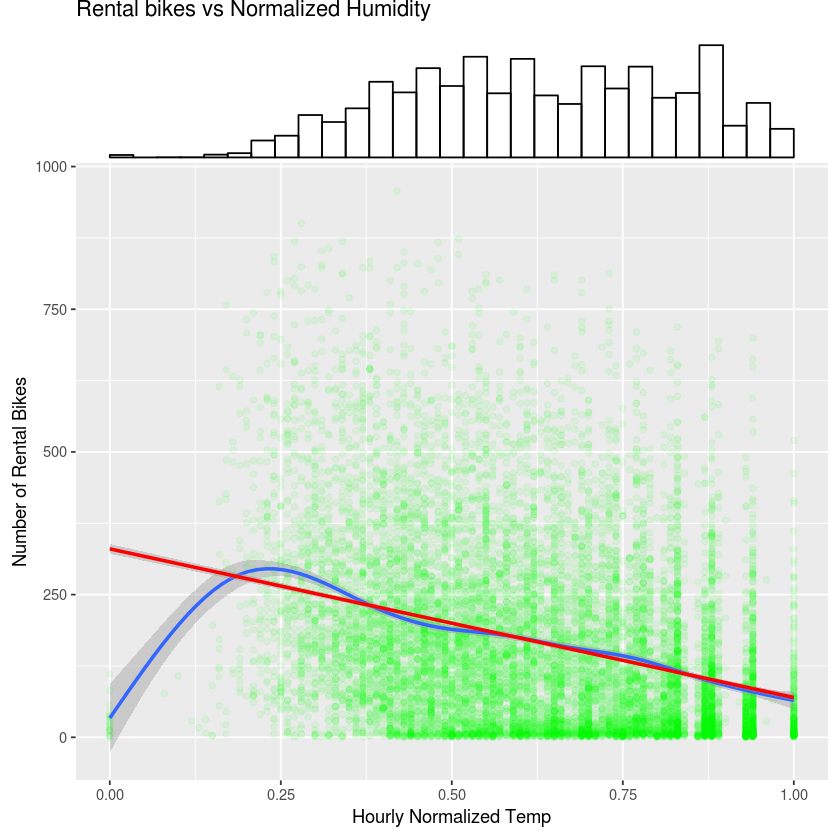

In [86]:
#From correlation table, it was negatively correlated
g2<-ggplot(train,aes(x=hum,y=cnt)) +
    geom_point(alpha=0.07, color='green')+
    labs(x="Hourly Normalized Temp",y="Number of Rental Bikes",
         title = "Rental bikes vs Normalized Humidity")+
    geom_smooth(method='auto')+
    geom_smooth(method='lm',color= 'red')
ggMarginal(g2, type = "histogram",fill="transparent", margins=c("x"))


6-Feature Engineering

6.1- Granger Causality to find optimal lag for hum and temp

In [157]:
#names(train)
ts<-train %>%
  dplyr::select(dteday, temp,hum, cnt)
head(ts)
#For granger Causality series must be stationary.
options(warn=-1)
adf.test(ts$temp)
#plot(ts$temp)
adf.test(ts$hum)
#plot(ts$hum)
adf.test(ts$cnt)
#plot(ts$cnt)
#Since they are stationary, no need for taking the difference
#tempdif<-diff(ts$temp)
#humdif<-diff(ts$hum)
#cntdif<-diff(ts$cnt)
#adf.test(tempdif)
#adf.test(humdif)
#adf.test(cntdif)

dteday,temp,hum,cnt
<date>,<dbl>,<dbl>,<int>
2011-01-01,0.24,0.81,16
2011-01-01,0.22,0.80,40
2011-01-01,0.22,0.80,32
2011-01-01,0.24,0.75,13
2011-01-01,0.24,0.75,1
2011-01-01,0.24,0.75,1



	Augmented Dickey-Fuller Test

data:  ts$temp
Dickey-Fuller = -4.5704, Lag order = 23, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  ts$hum
Dickey-Fuller = -12.004, Lag order = 23, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  ts$cnt
Dickey-Fuller = -7.2723, Lag order = 23, p-value = 0.01
alternative hypothesis: stationary


In [158]:
#temp and hum are time series and with a lag, they probably influence cnt. Therefore, I will use
#Granger-Causality to find these effects to include data set as a new variable.
#data set for temp
#attach(ts)

dtemp<-cbind(temp,cnt)
dhum<-cbind(hum,cnt)

#Find optimal lag for temp as granger caue
var <- VAR(dtemp, lag.max = 10, type = "const", ic ="AIC") # find optimal lag by AIC criteria
causality(var, cause = "temp")$Granger

#Find optimal lag for hum as granger cause
var1 <- VAR(dhum, lag.max = 10, type = "const", ic ="AIC") # find optimal lag by AIC criteria
causality(var1, cause = "hum")$Granger


	Granger causality H0: temp do not Granger-cause cnt

data:  VAR object var
F-Test = 141.2, df1 = 10, df2 = 25944, p-value < 2.2e-16



	Granger causality H0: hum do not Granger-cause cnt

data:  VAR object var1
F-Test = 55.473, df1 = 10, df2 = 25944, p-value < 2.2e-16


In [159]:
#From Granger causality it seems temp and hum values affect the values of "cnt". So, i will include 
#some lag values of these variables as new variables.
#For temprature first 3
data$lagtemp1<-0
data$lagtemp2<-0
data$lagtemp3<-0

data$lagtemp1[2:17379]=data$temp[1:17378]
data$lagtemp2[3:17379]=data$temp[1:17377]
data$lagtemp3[4:17379]=data$temp[1:17376]

#For humidty second and third
data$laghum2<-0
data$laghum3<-0

data$laghum2[3:17379]=data$hum[1:17377]
data$laghum3[4:17379]=data$hum[1:17376]

head(data)
tail(data)

dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,⋯,windspeed,cnt,lag1,lag2,lag3,lagtemp1,lagtemp2,lagtemp3,laghum2,laghum3
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-01,1,0,1,0,0,6,0,1,0.24,⋯,0.0000,16,0,0,0,0.00,0.00,0.00,0.00,0.00
2011-01-01,1,0,1,1,0,6,0,1,0.22,⋯,0.0000,40,16,0,0,0.24,0.00,0.00,0.00,0.00
2011-01-01,1,0,1,2,0,6,0,1,0.22,⋯,0.0000,32,40,16,0,0.22,0.24,0.00,0.81,0.00
2011-01-01,1,0,1,3,0,6,0,1,0.24,⋯,0.0000,13,32,40,16,0.22,0.22,0.24,0.80,0.81
2011-01-01,1,0,1,4,0,6,0,1,0.24,⋯,0.0000,1,13,32,40,0.24,0.22,0.22,0.80,0.80
2011-01-01,1,0,1,5,0,6,0,2,0.24,⋯,0.0896,1,1,13,32,0.24,0.24,0.22,0.75,0.80


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,⋯,windspeed,cnt,lag1,lag2,lag3,lagtemp1,lagtemp2,lagtemp3,laghum2,laghum3
,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17374,2012-12-31,1,1,12,18,0,1,1,2,0.26,⋯,0.1343,122,164,214,315,0.26,0.26,0.28,0.48,0.45
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,⋯,0.1642,119,122,164,214,0.26,0.26,0.26,0.48,0.48
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,⋯,0.1642,89,119,122,164,0.26,0.26,0.26,0.48,0.48
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,⋯,0.1642,90,89,119,122,0.26,0.26,0.26,0.60,0.48
17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,⋯,0.1343,61,90,89,119,0.26,0.26,0.26,0.60,0.60
17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,⋯,0.1343,49,61,90,89,0.26,0.26,0.26,0.60,0.60


6.2 One Hot Encoding

In [164]:
#One hot encoding for the categorical variable
ohe = dummyVars("~.", data[, !(colnames(data) %in% c("dteday"))], fullRank = T) 
ohe_df = data.table(predict(ohe, data[, !(colnames(data) %in% c("dteday"))])) 
combi = cbind(data[,"dteday"], ohe_df)
combi$V1<-NULL #it will not be used for prediction

tail(combi)
#Again splitting train and test data
train = combi[1:nrow(train)]
test = combi[(nrow(train) + 1):nrow(combi)] 
test[,cnt := NULL] # removing Item_Outlet_Sales as it contains only NA for test dataset
tail(train)
tail(test)

season.2,season.3,season.4,yr.1,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,mnth.7,⋯,windspeed,cnt,lag1,lag2,lag3,lagtemp1,lagtemp2,lagtemp3,laghum2,laghum3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,1,0,0,0,0,0,0,⋯,0.1343,122,164,214,315,0.26,0.26,0.28,0.48,0.45
0,0,0,1,0,0,0,0,0,0,⋯,0.1642,119,122,164,214,0.26,0.26,0.26,0.48,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.1642,89,119,122,164,0.26,0.26,0.26,0.48,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.1642,90,89,119,122,0.26,0.26,0.26,0.60,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.1343,61,90,89,119,0.26,0.26,0.26,0.60,0.60
0,0,0,1,0,0,0,0,0,0,⋯,0.1343,49,61,90,89,0.26,0.26,0.26,0.60,0.60


season.2,season.3,season.4,yr.1,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,mnth.7,⋯,windspeed,cnt,lag1,lag2,lag3,lagtemp1,lagtemp2,lagtemp3,laghum2,laghum3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,1,0,0,0,0,1,0,⋯,0.0000,339,362,373,404,0.88,0.90,0.88,0.29,0.30
0,1,0,1,0,0,0,0,1,0,⋯,0.2537,374,339,362,373,0.88,0.88,0.90,0.32,0.29
0,1,0,1,0,0,0,0,1,0,⋯,0.1642,292,374,339,362,0.84,0.88,0.88,0.35,0.32
0,1,0,1,0,0,0,0,1,0,⋯,0.1642,213,292,374,339,0.82,0.84,0.88,0.44,0.35
0,1,0,1,0,0,0,0,1,0,⋯,0.1642,172,213,292,374,0.82,0.82,0.84,0.52,0.44
0,1,0,1,0,0,0,0,1,0,⋯,0.0896,152,172,213,292,0.78,0.82,0.82,0.52,0.52


season.2,season.3,season.4,yr.1,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,mnth.7,⋯,hum,windspeed,lag1,lag2,lag3,lagtemp1,lagtemp2,lagtemp3,laghum2,laghum3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,1,0,0,0,0,0,0,⋯,0.48,0.1343,164,214,315,0.26,0.26,0.28,0.48,0.45
0,0,0,1,0,0,0,0,0,0,⋯,0.60,0.1642,122,164,214,0.26,0.26,0.26,0.48,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.60,0.1642,119,122,164,0.26,0.26,0.26,0.48,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.60,0.1642,89,119,122,0.26,0.26,0.26,0.60,0.48
0,0,0,1,0,0,0,0,0,0,⋯,0.56,0.1343,90,89,119,0.26,0.26,0.26,0.60,0.60
0,0,0,1,0,0,0,0,0,0,⋯,0.65,0.1343,61,90,89,0.26,0.26,0.26,0.60,0.60


6.1 Correlation with new features

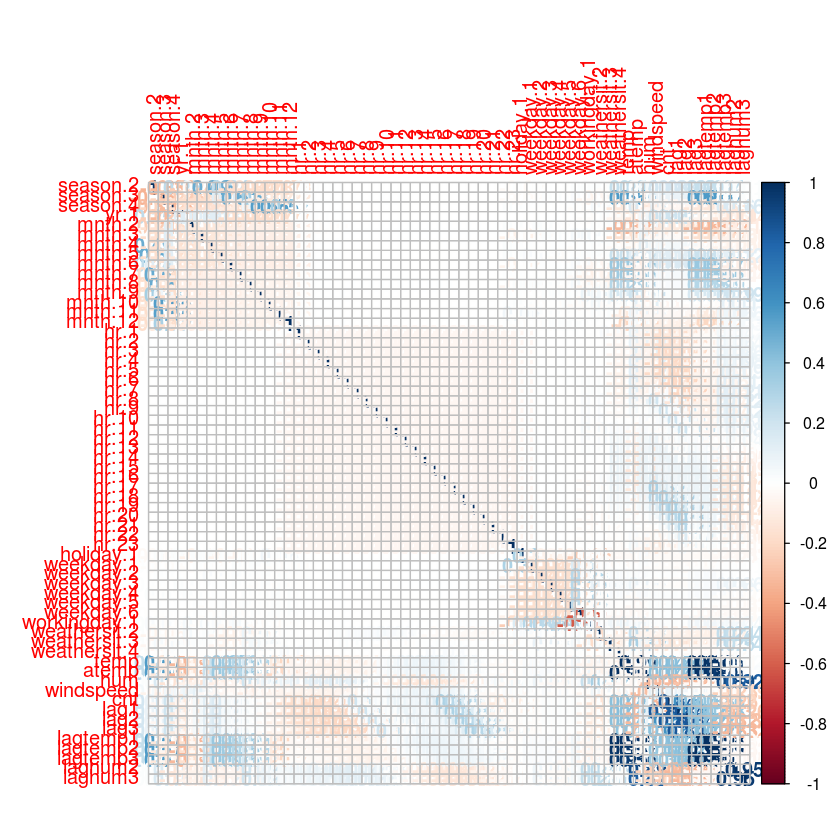

In [165]:
num<-select_if(train, is.numeric)#Extract numeric variables
#head(num)
M<-cor(num)# Correlation of numeric variables
corrplot(M,method = "number")#Correlation Plot
#str(train)

7-Model Building

In [166]:
#Bagginng
set.seed(1235)
bag_mod <- randomForest(cnt~., data=train, ntree=250, proximity=T, importance=T,mtry=61)
# Using Random forest model with mtry= number of all independent variables


Call:
 randomForest(formula = cnt ~ ., data = train, ntree = 250, proximity = T,      importance = T, mtry = 61) 
               Type of random forest: regression
                     Number of trees: 250
No. of variables tried at each split: 61

          Mean of squared residuals: 1006.353
                    % Var explained: 96.11

,%IncMSE,IncNodePurity
season.2,12.3535574,169832.41
season.3,4.2061218,65533.42
season.4,4.5720973,71029.18
yr.1,420.4908654,2273569.41
mnth.2,3.4119535,60024.11
mnth.3,5.9972995,83613.08
mnth.4,4.1016094,102290.99
mnth.5,1.8077911,100080.65
mnth.6,6.4405523,114448.75
mnth.7,0.1925838,30535.22


[1] 2316.681


[1] 48.13192

[1] "The root mean squared error is: 48.1319173846199"

[1] 30.94013


[1] "The mean absolute error is: 30.9401315051798"

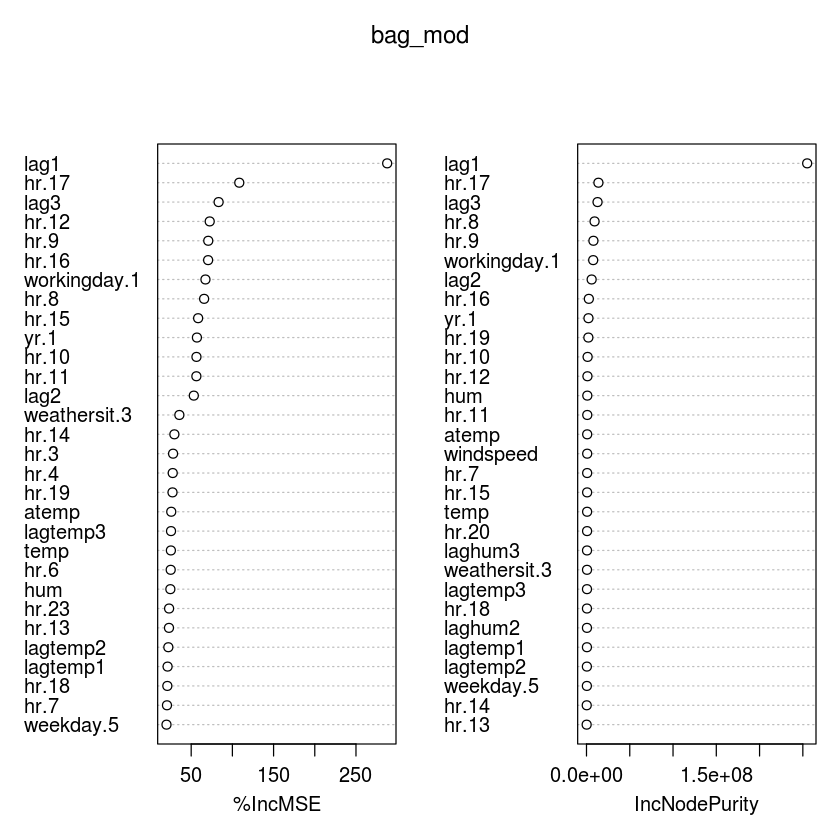

In [167]:
bag_mod
#Importance of variables
bag_mod$importance
varImpPlot(bag_mod)

#predict test data
pre_bag   <- predict(bag_mod, test)
#Calculate error
#MSE
mse_bag<-(1/length(y))*sum((y-pre_bag)^2)
print(mse_bag)#[1] 2316.681
sqrt(mse_bag)#48.1319173846199
paste("The root mean squared error is:",sqrt(mse_bag))
#predict test data
#MAE
mae_bag<-(1/length(y))*sum(abs(y-pre_bag))
print(mae_bag)#[1]  30.94013
paste("The mean absolute error is:",mae_bag)

    7.1 Visualization of Prediction vs. Actual Values

'data.frame':	4376 obs. of  3 variables:
 $ pre_bag: num  115.26 114.89 63.79 42.95 9.19 ...
 $ actual : int  149 93 90 33 4 10 27 50 142 219 ...
 $ id     : int  1 2 3 4 5 6 7 8 9 10 ...


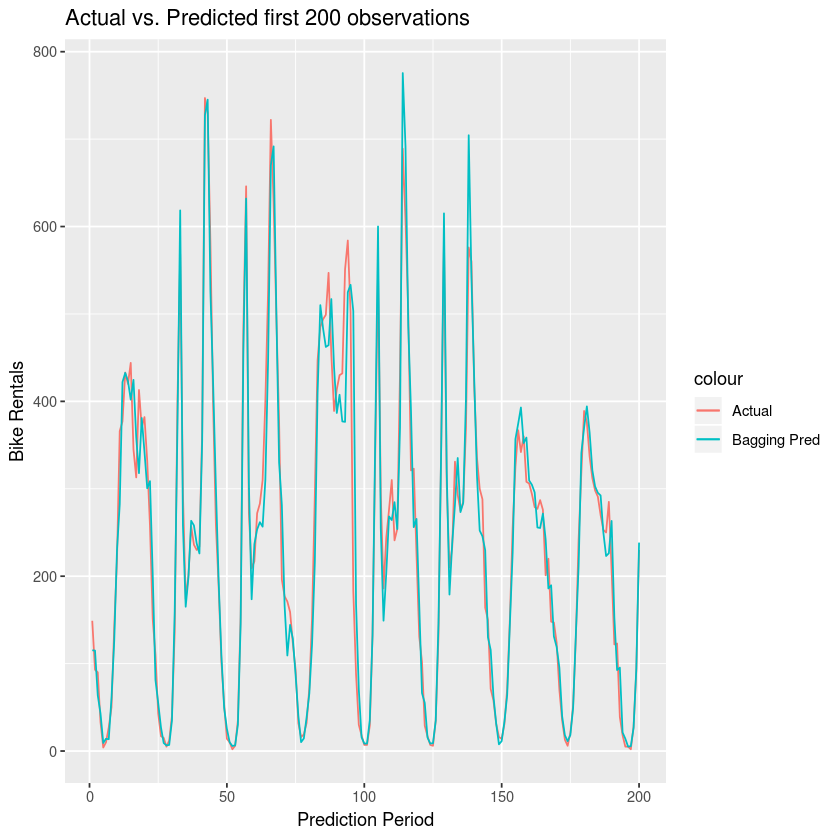

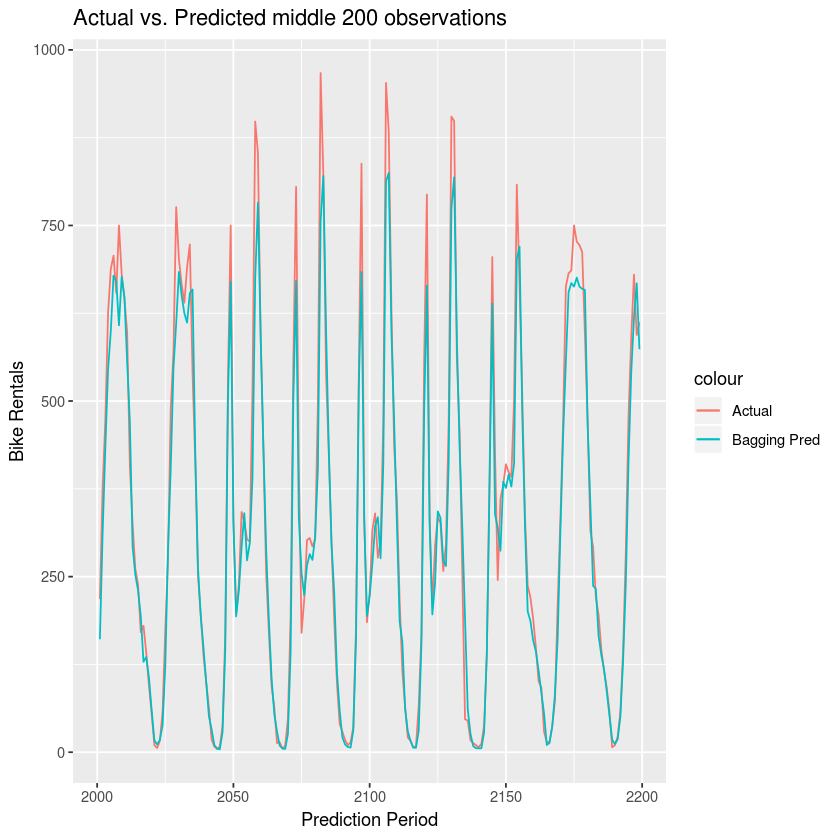

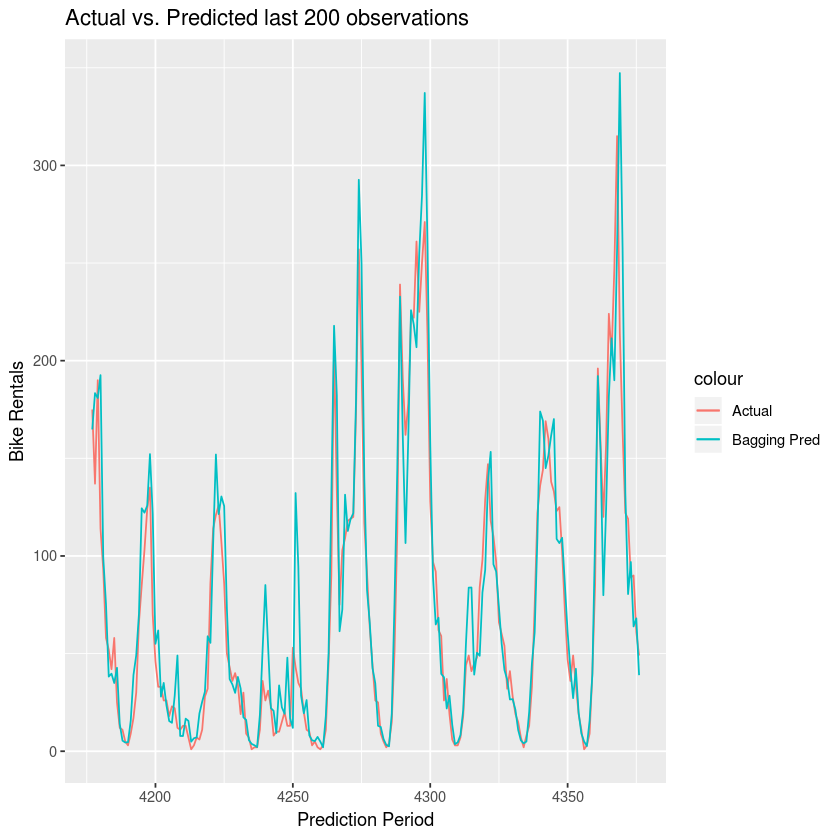

In [168]:
dfpred<-as.data.frame(pre_bag)#Predictions as a data frame
dfpred$actual<-y#Add actual values to prediction data frame
dfpred$id<-1:nrow(dfpred)#add index
str(dfpred)

#Visualize the results
ggplot(dfpred%>%filter(id<=200))+
  geom_line(aes(x=id, y=actual, color="Actual"))+
  geom_line(aes(x=id, y=pre_bag, color = "Bagging Pred"))+
  labs(y="Bike Rentals",x="Prediction Period",title = "Actual vs. Predicted first 200 observations")

ggplot(dfpred%>%filter(2200 > id & id>2000))+
  geom_line(aes(x=id, y=actual, color="Actual"))+
  geom_line(aes(x=id, y=pre_bag, color = "Bagging Pred"))+
  labs(y="Bike Rentals",x="Prediction Period",title = "Actual vs. Predicted middle 200 observations")

ggplot(dfpred%>%filter(id>4176))+
  geom_line(aes(x=id, y=actual, color="Actual"))+
  geom_line(aes(x=id, y=pre_bag, color = "Bagging Pred"))+
  labs(y="Bike Rentals",x="Prediction Period",title = "Actual vs. Predicted last 200 observations")